In [1]:
import pandas as pd
import numpy as np

In [2]:
df_xml = pd.read_xml("./MCC.XML")
pd.set_option('display.precision', 15)

df_xml

,StringValue,NumberOfParameters,Service,TechnicalEventType,TechnicalID,Description,TimeStamp,ProcessName,MemoField
0,Memo-field,NaN,None,None,NaN,None,None,None,None
1,None,232666.0,None,None,NaN,None,None,None,None
2,None,NaN,Field Service,Technical Event,620000001.0,Services.FSF.Server.SessionManager.FSF_SERVER_...,2023-3-19 8:7:11.0,C:\Program Files\PMS\MIP\Philips.PmsMip.Privat...,[FREE_TEXT] \n[FREE_TEXT] ... 1. SessionDetai...
3,None,NaN,Field Service,Technical Event,620000001.0,Services.FSF.Server.SessionManager.FSF_SERVER_...,2023-3-19 8:7:4.0,C:\Program Files\PMS\MIP\Philips.PmsMip.Privat...,[FREE_TEXT] \n[FREE_TEXT] ... 1. SessionDetai...
4,None,NaN,Field Service,Internal Event,620170007.0,FSC UI module,2023-3-19 8:5:5.0,C:\Program Files\PMS\MIP\Philips.PmsMip.Privat...,[FREE_TEXT] \n[FREE_TEXT] [FSCUiM] CFSCUiMTsm...
...,...,...,...,...,...,...,...,...,...
232663,None,NaN,Acquisition,Local Func. Request,510999921.0,Command: StartFluoroscopy,2023-2-27 11:56:15.0,C:\Program Files\PMS\Fusion\Acq_acquisition_pr...,[FREE_TEXT] \n[FUSION_COMMAND] StartFluorosco...
232664,None,NaN,Reviewing,Local Func. Request,520019921.0,Command: StopStepRunFwd,2023-2-27 11:56:11.0,C:\Program Files\PMS\Fusion\Rev_reviewing_prod...,[FREE_TEXT] \n[FUSION_COMMAND] StopStepRunFwd...
232665,None,NaN,Reviewing,Local Func. Request,520019921.0,Command: StartStepRunFwd,2023-2-27 11:56:10.0,C:\Program Files\PMS\Fusion\Rev_reviewing_prod...,[FREE_TEXT] \n[FUSION_COMMAND] StartStepRunFw...
232666,None,NaN,Reviewing,Local Func. Request,520019921.0,Command: StopStepRunFwd,2023-2-27 11:56:9.0,C:\Program Files\PMS\Fusion\Rev_reviewing_prod...,[FREE_TEXT] \n[FUSION_COMMAND] StopStepRunFwd...


In [81]:

import matplotlib.pyplot as plt


# from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.multioutput import MultiOutputRegressor
from sklearn.linear_model import LinearRegression
# from sklearn.compose import ColumnTransformer
from sklearn.base import BaseEstimator,TransformerMixin
from sklearn.model_selection import train_test_split 
from sklearn.metrics import mean_squared_error as mse
from sklearn.preprocessing import PolynomialFeatures

from sklearn.svm import SVR

pd.set_option('display.precision', 15)


class train_linear(BaseEstimator , TransformerMixin):
    def __init__(self ):
        
#         self.df = df
        
#         self.pipeline = Pipeline([
#             ("scale" , StandardScaler()) , 
# #             ("train" , MultiOutputRegressor(LinearRegression()))
#         ])
        self.model_large , self.model_small = None , None
      
        
        
    def calc_rmse(self , y_true , y_pred):
        
        rmse = mse(y_true , y_pred , squared = False)
        
        return rmse
        
        
    ####### To DO : --
        
    
    

    def sort_data(self,data):
        """
         Create a Function to sort the dataframe based on the timestamp column before extracting the cumulative
         returns the dataframe with three columns sorted
    
        """
        data["TimeStamp"]  =pd.to_datetime(data['TimeStamp'], format='mixed')
        data = data.sort_values("TimeStamp")
        data.drop("TimeStamp" , inplace = True , axis=1)
        
        return data
    
    
    def prep_data(self,  df = None):
        if df is None:
            raise Exception("No data were passed , pass dataframe")
            
        pd.set_option('display.precision', 15)

        df_copy = df.copy()


#         df.dropna(inplace=True )
#         df.reset_index(drop=True,inplace=True)


        print(f"Extracting Data from Message Column.......")
        df = df[df.apply(lambda row: row.astype(str).str.contains('\[Focus=Largest\]').any(), axis=1)];
        df_small = df_copy[df_copy.apply(lambda row: row.astype(str).str.contains('\[Focus=Smallest\]').any(), axis=1)];
        
        
        df['RunLength'] = df["MemoField"].str.extract(r'RunLength=[^\d]*(\d+(?:\.\d+)?)');
        df["N_Pulses"] =  df["MemoField"].str.extract(r'NumberOfPulses=[^\d]*(\d+(?:\.\d+)?)');
        df["NewCFactor"] = df["MemoField"].str.extract(r'NewCFactor=[^\d]*(\d+(?:\.\d+)?)');
        df = df[["TimeStamp" ,"NewCFactor" , "N_Pulses" , "RunLength" ]]   
        
        for col in ["N_Pulses","NewCFactor" , "RunLength"]:
            df[col] = df[col].astype("float64")

        df = self.sort_data(df)

        df["RunLength_Cum"] = np.cumsum(df["RunLength"])
        df["N_Pulses_Cum"] = np.cumsum(df["N_Pulses"])
        
        
        ############# smallest
        df_small['RunLength'] = df_small["MemoField"].str.extract(r'RunLength=[^\d]*(\d+(?:\.\d+)?)');
        df_small["N_Pulses"] =  df_small["MemoField"].str.extract(r'NumberOfPulses=[^\d]*(\d+(?:\.\d+)?)');
        df_small["NewCFactor"] = df_small["MemoField"].str.extract(r'NewCFactor=[^\d]*(\d+(?:\.\d+)?)');
        
        df_small = df_small[["TimeStamp" ,"NewCFactor" , "N_Pulses" , "RunLength" ]]    
    
        for col in ["N_Pulses","NewCFactor" , "RunLength"]:
            df_small[col] = df_small[col].astype("float64")
        
        df_small = self.sort_data(df_small)



        df_small["RunLength_Cum"] = np.cumsum(df_small["RunLength"])
        df_small["N_Pulses_Cum"] = np.cumsum(df_small["N_Pulses"])
        
#         df_small = df_small[["RunLength_Cum","N_Pulses_Cum","NewCFactor" ]]
#         df = df[["RunLength_Cum","N_Pulses_Cum","NewCFactor" ]]
        
#         print(df_small.shape , df.shape)
        
        
        
        return df , df_small
    
    
    def fit(self , df=None):
        """
        returns (prepared dataframe , fitted pipeline)
        """
    
        if df is None:
            raise Exception("No data were passed , pass dataframe")
            
        df  , df_small = self.prep_data(df)
            

        

#         self.pipeline.fit(df)
        
        print("Data Prepration Done")
        return df , df_small # , self.pipeline
    

        
        
        
    def train_df(self,trans_df):
        
        X = trans_df[["NewCFactor"]]
        
        y = trans_df[["RunLength_Cum", "N_Pulses_Cum"]]
        
        X_train , X_test ,y_train , y_test = train_test_split(X , y ,test_size = 0.2)
        
        ##### Scaling
        
        scaler = StandardScaler()
        
        y_train = pd.DataFrame(scaler.fit_transform(y_train) 
                               , columns=["RunLength_Cum","N_Pulses_Cum"])
        
        y_test = pd.DataFrame(scaler.transform(y_test)
                              , columns=["RunLength_Cum","N_Pulses_Cum"])

        
        
        
        ##### Polynomial 
        
        
#         degree = 2
        
#         poly = PolynomialFeatures(degree)
#         X_train = poly.fit_transform(X_train)
#         X_test = poly.transform(X_test)
        
        
        lr = MultiOutputRegressor(LinearRegression())
        
        
#         lr = SVR()
        
        lr.fit(X_train ,y_train)
        
        train_pred = lr.predict(X_train)
        
        print(f"RMSE for train RunLength_Cum : {self.calc_rmse(y_train['RunLength_Cum'] , train_pred[:,0])}")
        print(f"RMSE for train N_Pulses_Cum : {self.calc_rmse(y_train['N_Pulses_Cum'] , train_pred[:,1])}")

        plt.scatter(X_train,y_train["RunLength_Cum"] ,label="Actual Values For RunLength_Cum")
        plt.scatter(X_train,y_train["N_Pulses_Cum"],label="Actual Values For N_pulses_Cum" , color='cyan')

        plt.plot(X_train ,train_pred , label="Predictions" , color='red')
        
        plt.title("Model Performence On Train data")
        plt.legend()
        plt.show()
        
        test_pred = lr.predict(X_test)
        
        print(f"RMSE for test RunLength_Cum : {self.calc_rmse(y_test['RunLength_Cum'] , test_pred[:,0])}")
        print(f"RMSE for test N_Pulses_Cum : {self.calc_rmse(y_test['N_Pulses_Cum'] , test_pred[:,1])}")
        
        plt.scatter(X_test,y_test["RunLength_Cum"] ,label="Actual Values For RunLength")
       
        plt.scatter(X_test,y_test["N_Pulses_Cum"],label="Actual Values For N_pulses" , color='cyan')

        plt.plot(X_test ,test_pred , label="Predictions" , color='red')
        
        plt.title("Model Performence On Test data")
        plt.legend()
        plt.show()
        
#         self.model = lr
        
        return lr
    
    
    def train(self,df, df_small):
        self.model_large = self.train_df(df)
        self.model_small = self.train_df(df_small)
        
        
        
        
        
    def predict(self,df,prep = False):
        
        if prep == False :
            try:
                self.model.predict(df)
            except Exception as ex:
                print(f"Something Wrong with data , Try run fit first {ex}")
                
        elif prep ==True:
            if isinstance(df , pd.DataFrame):
                df = self.fit(df)
                if len(df.columns) > 1:
                    df = df[["NewCFactor"]]
                preds_large = self.model_large.predict(df)
                preds_small = self.model_small.predict(df)
            elif isinstance(df, np.ndarray):
                
                df = pd.DataFrame(df , columns=["NewCFactor"])
                preds_large = self.model_large.predict(df)
                preds_small = self.model_small.predict(df)
            
            preds_large = pd.DataFrame(preds_large , columns=["RunLength_Cum_large",'N_Pulses_Cum_large'])

            preds_small = pd.DataFrame(preds_small , columns=["RunLength_Cum_small",'N_Pulses_Cum_small'])

            preds = pd.concat([preds_large , preds_small],axis=1)
            return preds.astype(int)

In [82]:
train = train_linear()

In [83]:
preped_df ,preped_small = train.fit(df_xml)

preped_df

Extracting Data from Message Column.......
Data Prepration Done


/tmp/ipykernel_21729/1240244763.py:75: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['RunLength'] = df["MemoField"].str.extract(r'RunLength=[^\d]*(\d+(?:\.\d+)?)');
/tmp/ipykernel_21729/1240244763.py:76: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["N_Pulses"] =  df["MemoField"].str.extract(r'NumberOfPulses=[^\d]*(\d+(?:\.\d+)?)');
/tmp/ipykernel_21729/1240244763.py:77: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] 

,NewCFactor,N_Pulses,RunLength,RunLength_Cum,N_Pulses_Cum
232568,0.995550274848938,47.0,3.65319991111755,3.653199911117550,47.0
232465,0.995550274848938,37.0,3.09990000724792,6.753099918365470,84.0
232292,0.995551943778992,14.0,1.44430005550385,8.197399973869320,98.0
232233,0.995553493499756,31.0,2.57520008087158,10.772600054740900,129.0
232099,0.995553493499756,31.0,2.58080005645752,13.353400111198420,160.0
...,...,...,...,...,...
1080,0.994879364967346,47.0,3.83660006523132,12804.969230741260617,80212.0
1039,0.994879364967346,48.0,3.91549992561340,12808.884730666874020,80260.0
974,0.994879364967346,6.0,1.11710000038147,12810.001830667255490,80266.0
911,0.994879364967346,55.0,4.40159988403320,12814.403430551288693,80321.0


RMSE for train RunLength_Cum : 0.3644291312987661
RMSE for train N_Pulses_Cum : 0.28508437589759156


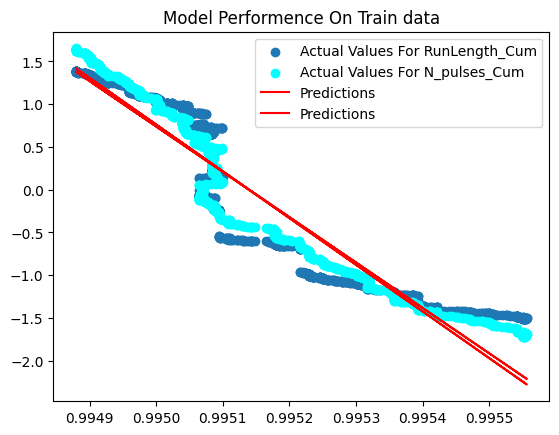

RMSE for test RunLength_Cum : 0.36014092639638506
RMSE for test N_Pulses_Cum : 0.28005146532255726


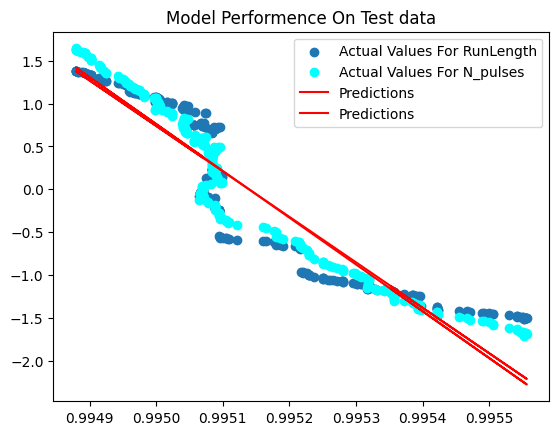

RMSE for train RunLength_Cum : 0.2219241659349851
RMSE for train N_Pulses_Cum : 0.22679014610207537


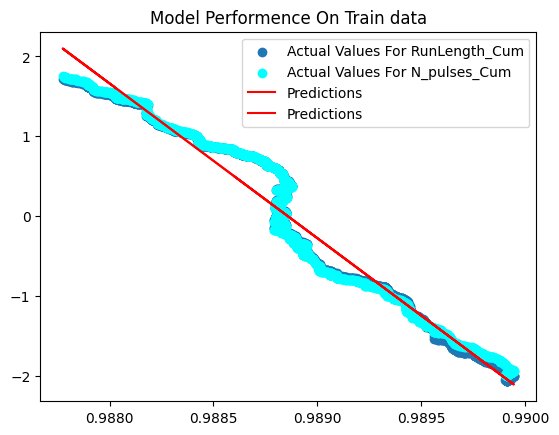

RMSE for test RunLength_Cum : 0.2161540591541157
RMSE for test N_Pulses_Cum : 0.22274174845308325


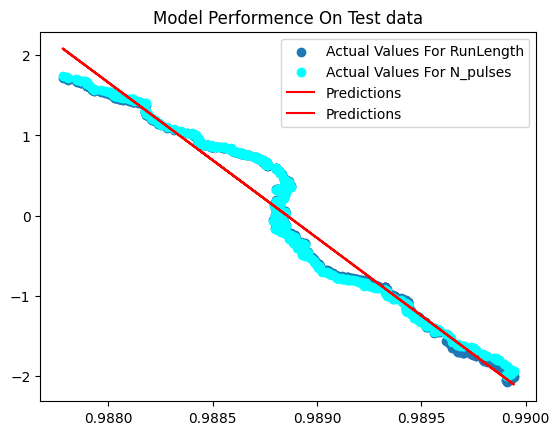

In [84]:
train.train(preped_df , preped_small)

In [90]:
fail_point = 0.9053574604

preds =train.predict(np.array([[fail_point]]) , prep= True)
preds

,RunLength_Cum_large,N_Pulses_Cum_large,RunLength_Cum_small,N_Pulses_Cum_small
0,476,490,161,161


In [100]:
2095056.27113517 / 3600

581.960075315325

# EDA

In [40]:
preped_df

,NewCFactor,N_Pulses,RunLength,RunLength_Cum,N_Pulses_Cum
232568,0.995550274848938,47.0,3.65319991111755,3.653199911117550,47.0
232465,0.995550274848938,37.0,3.09990000724792,6.753099918365470,84.0
232292,0.995551943778992,14.0,1.44430005550385,8.197399973869320,98.0
232233,0.995553493499756,31.0,2.57520008087158,10.772600054740900,129.0
232099,0.995553493499756,31.0,2.58080005645752,13.353400111198420,160.0
...,...,...,...,...,...
1080,0.994879364967346,47.0,3.83660006523132,12804.969230741260617,80212.0
1039,0.994879364967346,48.0,3.91549992561340,12808.884730666874020,80260.0
974,0.994879364967346,6.0,1.11710000038147,12810.001830667255490,80266.0
911,0.994879364967346,55.0,4.40159988403320,12814.403430551288693,80321.0


In [42]:
X = preped_df[["NewCFactor"]]

y = preped_df[["RunLength_Cum", "N_Pulses_Cum"]]

X_train , X_test ,y_train , y_test = train_test_split(X , y ,test_size = 0.2)


In [86]:
scaler = StandardScaler()

scaler.fit_transform(y_train)


array([[-1.09677759, -0.9616989 ],
       [-1.17357804, -1.14460309],
       [-1.51883316, -1.69712615],
       ...,
       [-1.22955412, -1.28525302],
       [ 0.94233762,  0.7570077 ],
       [ 1.29357873,  1.45708193]])

In [117]:
pd.concat([pd.DataFrame(scaler.inverse_transform(preds[preds.columns[:2]])
                        ,columns=scaler.get_feature_names_out()) ,
          pd.DataFrame(scaler.inverse_transform(preds[preds.columns[2:]])
                        ,columns=scaler.get_feature_names_out())] , axis=1) /3600

,RunLength_Cum,N_Pulses_Cum,RunLength_Cum,N_Pulses_Cum
0,581.960075315324389,3226.319974913396891,198.084427584823345,1067.812780530784494


In [116]:
np.array(["asd","asdgg"])

array(['asd', 'asdgg'], dtype='<U5')

In [46]:
from sklearn.svm import SVR

svr = SVR()

svr.fit(X_train , y_train["RunLength_Cum"])

SVR()

In [48]:
mse(y_train["RunLength_Cum"] , svr.predict(X_train) , squared=False)

4140.314856092332

In [49]:
from sklearn.linear_model import LinearRegression 
lr = LinearRegression()


lr.fit(X_train , y_train["RunLength_Cum"])

LinearRegression()

In [50]:
mse(y_train["RunLength_Cum"] , lr.predict(X_train) , squared=False)

1607.7393664468375

In [53]:
mse(y_test["RunLength_Cum"] , lr.predict(X_test) , squared=False)

1587.2198544344312